# Comprehensive Analysis of Library Database Records

This notebook performs in-depth analysis of the library database ecosystem using DuckDB for efficient querying of Parquet files. Each query loads its data directly to ensure proper handling of multiple files and partitions.

In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set a valid seaborn style
sns.set_theme(style="darkgrid")  # Or choose any other valid style

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = [12, 6]

# Initialize DuckDB with appropriate settings
con = duckdb.connect()
con.execute("SET memory_limit='27GB'")
con.execute("SET threads=16")

# Query 1: Analysis of record distribution across different sources
## Combines data from multiple archive sources to compare coverage

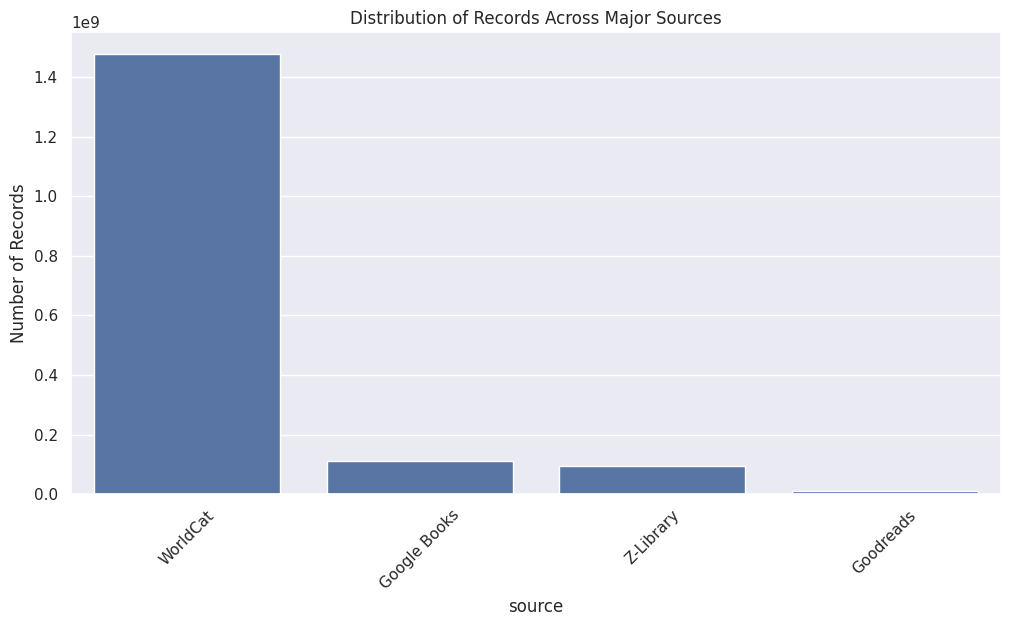

In [6]:
source_dist = con.execute("""
    WITH all_sources AS (
        SELECT 'Goodreads' as source, COUNT(*) as records
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__goodreads_records*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'WorldCat' as source, COUNT(*) as records
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__worldcat*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'Google Books' as source, COUNT(*) as records
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__gbooks_records*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'Z-Library' as source, COUNT(*) as records
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__zlib3_records*.parquet', union_by_name=True)
    )
    SELECT * FROM all_sources
    ORDER BY records DESC;
""").df()

plt.figure(figsize=(12, 6))
sns.barplot(data=source_dist, x='source', y='records')
plt.title('Distribution of Records Across Major Sources')
plt.xticks(rotation=45)
plt.ylabel('Number of Records')
plt.show()

# Query 2: Analysis of record ID prefixes distribution
## Examines the distribution of different types of identifiers

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

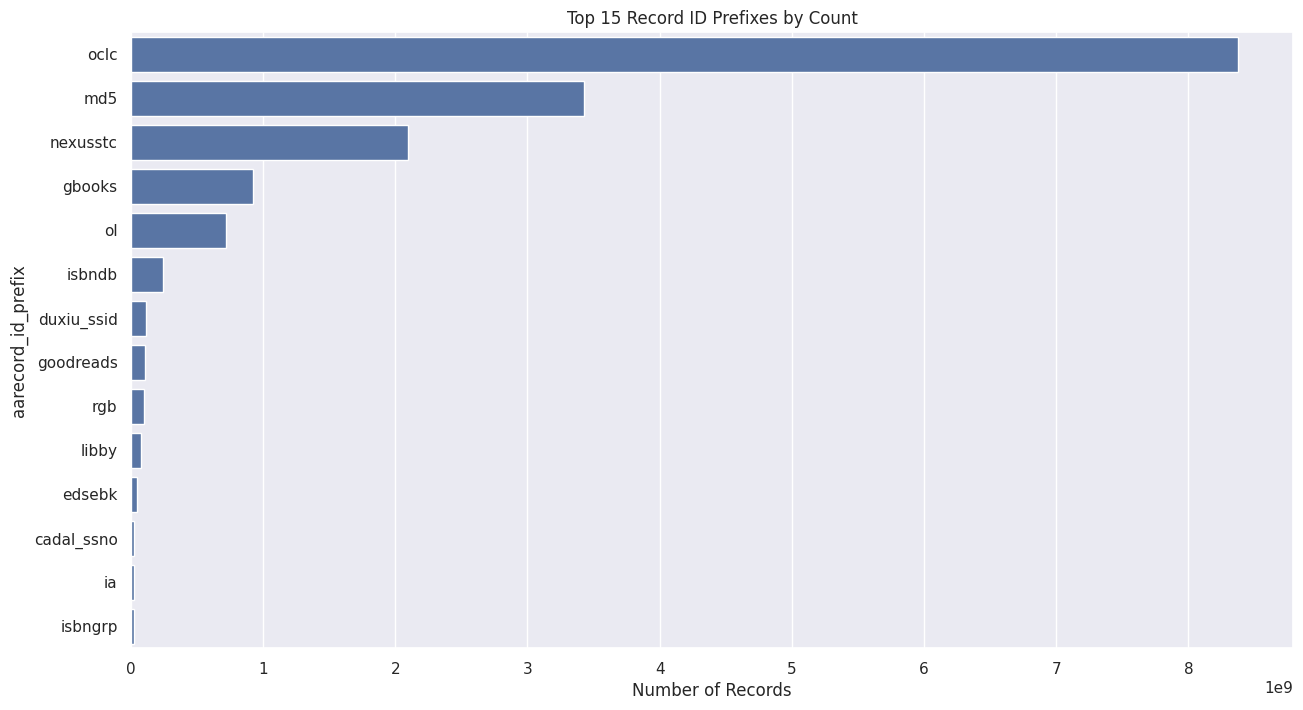

In [7]:
prefix_dist = con.execute("""
    WITH prefix_data AS (
        SELECT 
            aarecord_id_prefix,
            COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_aarecords_codes*.parquet', union_by_name=True)
        GROUP BY aarecord_id_prefix
    )
    SELECT * FROM prefix_data
    ORDER BY count DESC
    LIMIT 15;
""").df()

plt.figure(figsize=(15, 8))
sns.barplot(data=prefix_dist, x='count', y='aarecord_id_prefix')
plt.title('Top 15 Record ID Prefixes by Count')
plt.xlabel('Number of Records')
plt.show()

# Query 3: Series analysis from LibGen
## Analyzes the distribution and characteristics of book series

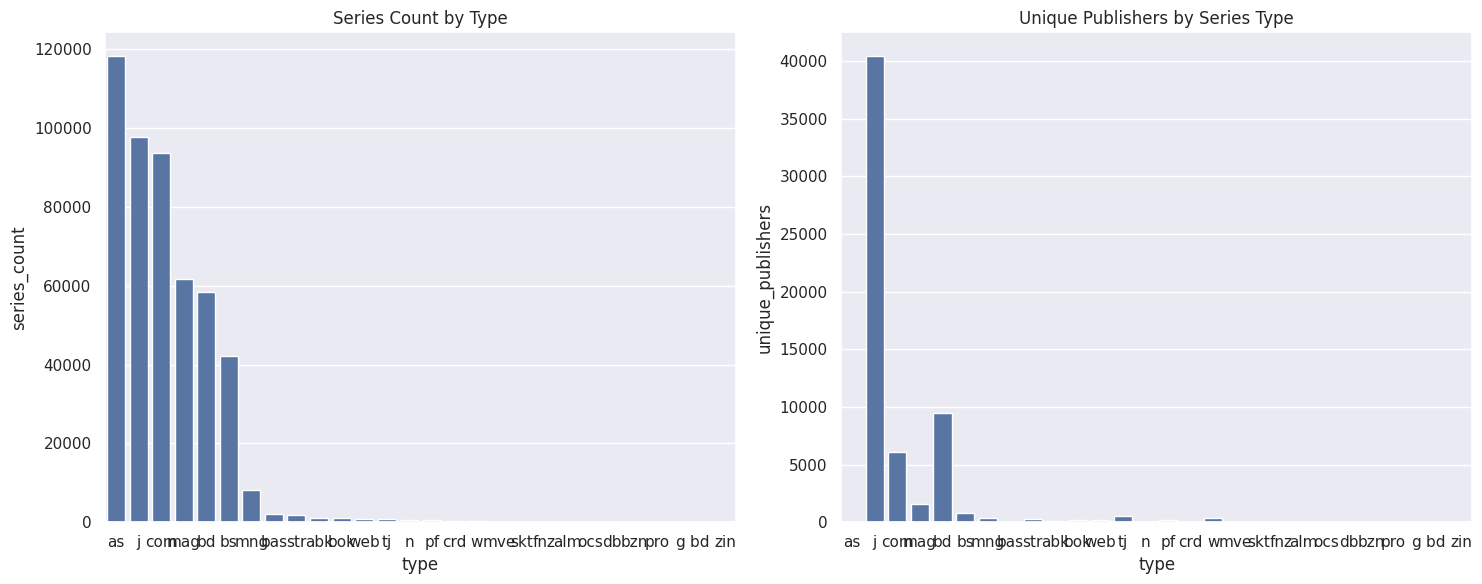

In [8]:
series_analysis = con.execute("""
    SELECT 
        type,
        COUNT(*) as series_count,
        COUNT(DISTINCT publisher) as unique_publishers
    FROM read_parquet('/data/mariadbF/mariadb_libgenli_series*.parquet', union_by_name=True)
    WHERE type IS NOT NULL
    GROUP BY type
    ORDER BY series_count DESC;
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(data=series_analysis, x='type', y='series_count', ax=ax1)
sns.barplot(data=series_analysis, x='type', y='unique_publishers', ax=ax2)
ax1.set_title('Series Count by Type')
ax2.set_title('Unique Publishers by Series Type')
plt.tight_layout()
plt.show()

# Query 4: Code prefix analysis
## Examines the distribution of code prefixes across different lookup tables

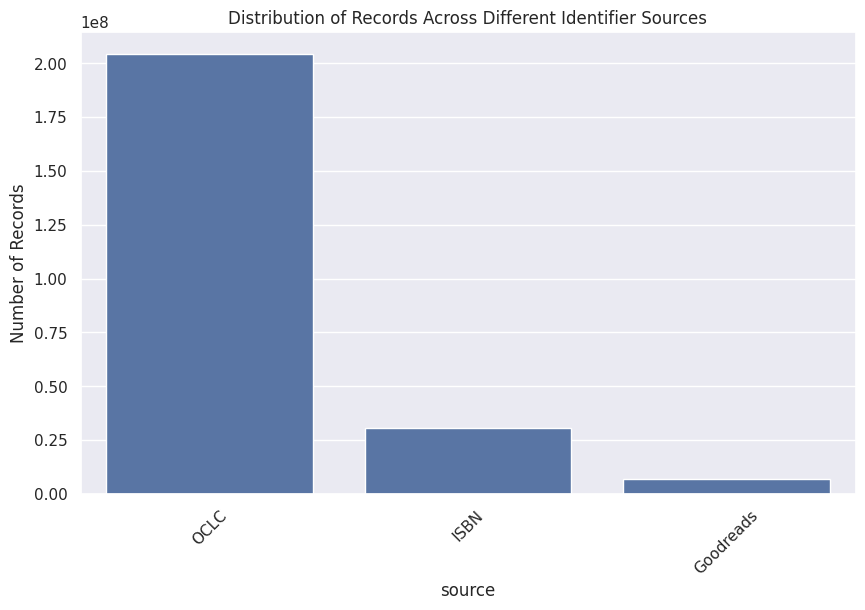

In [10]:
code_prefix_analysis = con.execute("""
    WITH prefix_counts AS (
        SELECT 'Goodreads' as source, COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_aarecords_codes_goodreads_for_lookup*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'OCLC' as source, COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_aarecords_codes_oclc_for_lookup*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'ISBN' as source, COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_aarecords_codes_isbndb_for_lookup*.parquet', union_by_name=True)
    )
    SELECT * FROM prefix_counts
    ORDER BY count DESC;
""").df()

plt.figure(figsize=(10, 6))
sns.barplot(data=code_prefix_analysis, x='source', y='count')
plt.title('Distribution of Records Across Different Identifier Sources')
plt.xticks(rotation=45)
plt.ylabel('Number of Records')
plt.show()

# Query 5: ZLib book analysis
## Analyzes the distribution of books in ZLib by language and file type

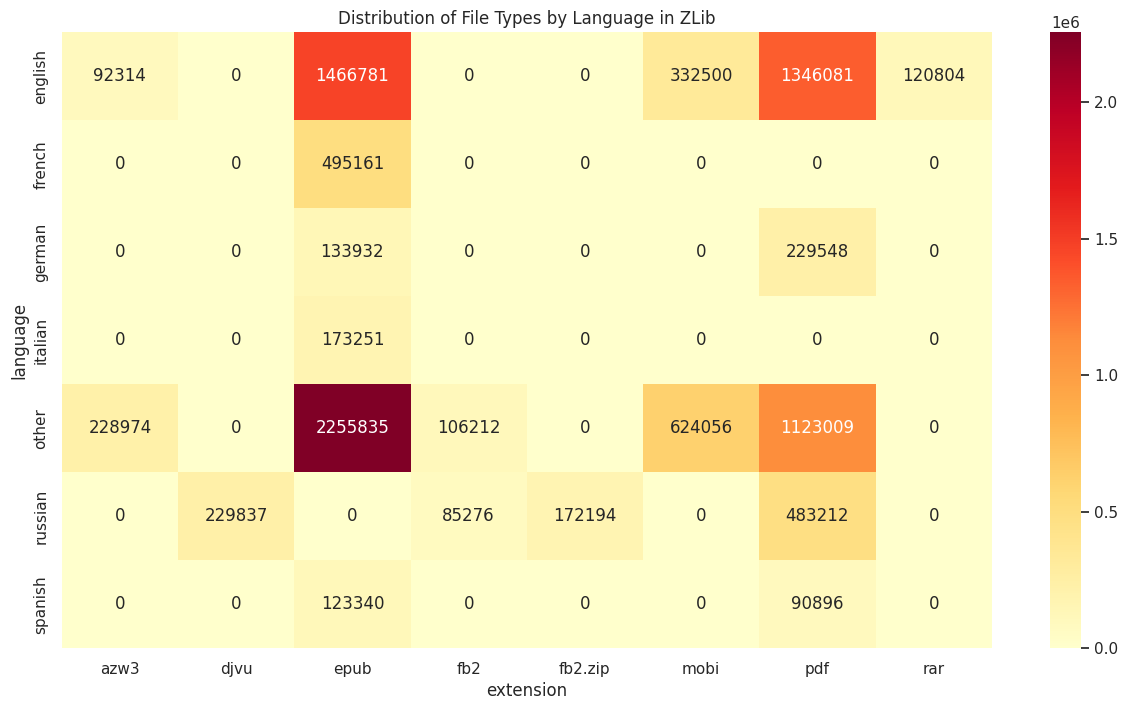

In [2]:
zlib_analysis = con.execute("""
    WITH lang_ext_stats AS (
        SELECT 
            language,
            extension,
            COUNT(*) as count,
            AVG(CAST(NULLIF(filesize, '\\N') AS DOUBLE))/1024/1024 as avg_size_mb
        FROM read_parquet('/data/mariadbF/mariadb_zlib_book*.parquet', union_by_name=True)
        WHERE language IS NOT NULL AND extension IS NOT NULL
        GROUP BY language, extension
    )
    SELECT * FROM lang_ext_stats
    ORDER BY count DESC
    LIMIT 20;
""").df()


plt.figure(figsize=(15, 8))
pivot_data = zlib_analysis.pivot(index='language', columns='extension', values='count').fillna(0)
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Distribution of File Types by Language in ZLib')
plt.show()

# Query 6: LibGen editions analysis
## Examines the temporal distribution of publications

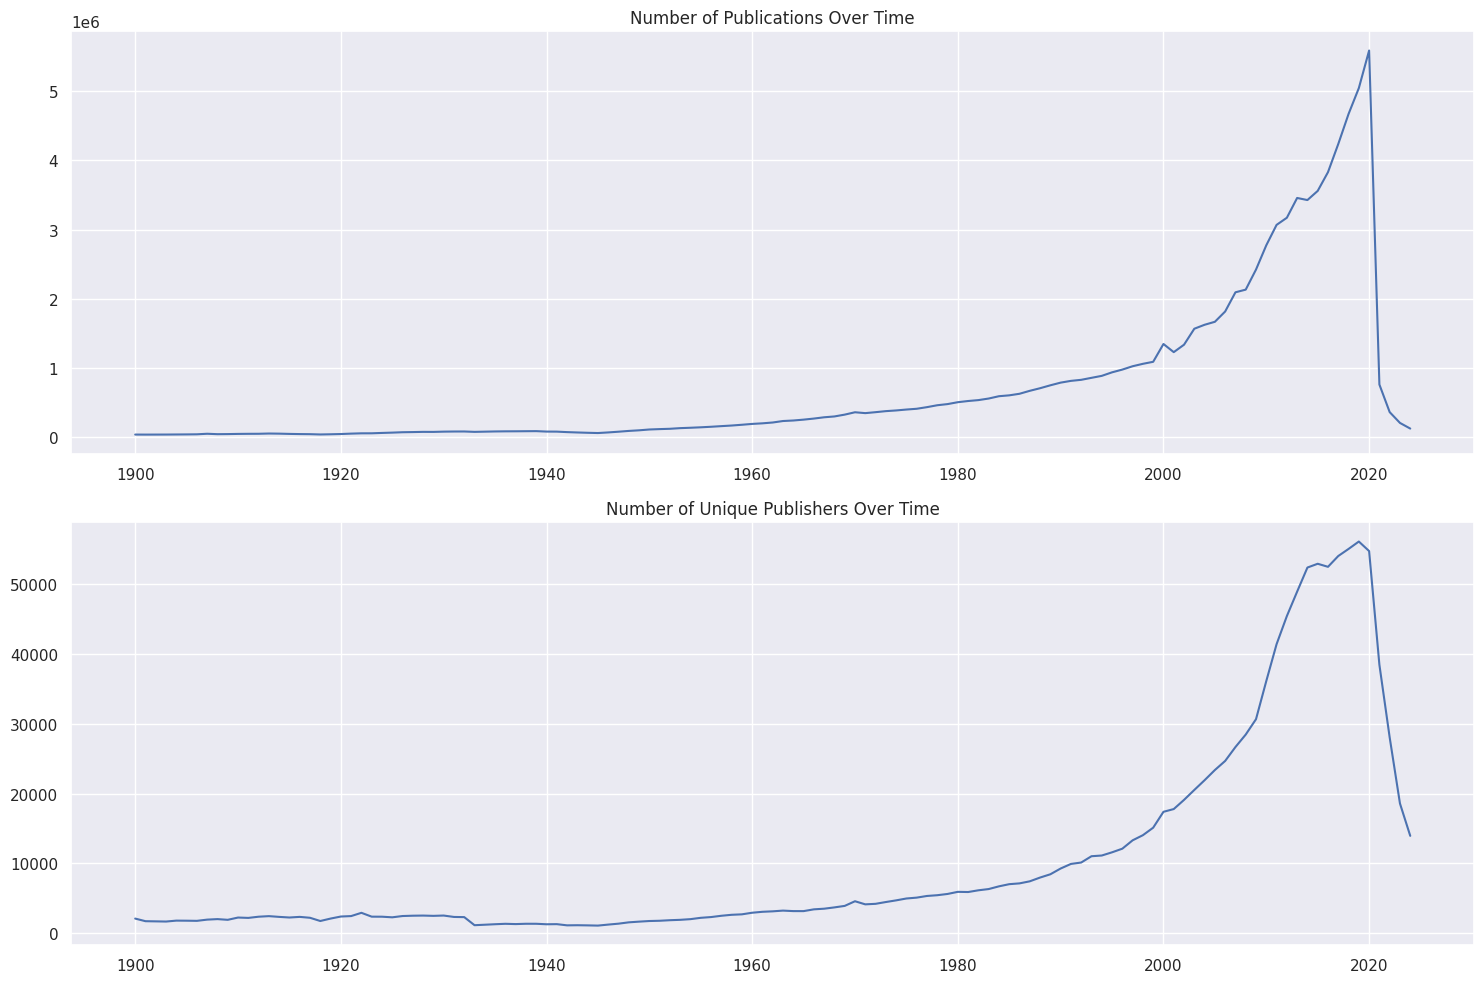

In [18]:
editions_analysis = con.execute("""
    SELECT 
        CAST(year AS INTEGER) AS year,
        COUNT(*) as publications,
        COUNT(DISTINCT publisher) as unique_publishers
    FROM read_parquet('/data/mariadbF/mariadb_libgenli_editions*.parquet', union_by_name=True)
    WHERE year ~ '^[0-9]{4}$'  -- This ensures only numeric 4-digit years are considered
    AND CAST(year AS INTEGER) BETWEEN 1900 AND 2024
    GROUP BY year
    ORDER BY year;
""").df()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(editions_analysis['year'], editions_analysis['publications'])
ax1.set_title('Number of Publications Over Time')
ax1.grid(True)

ax2.plot(editions_analysis['year'], editions_analysis['unique_publishers'])
ax2.set_title('Number of Unique Publishers Over Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Query 7: Archive metadata analysis
## Analyzes the distribution of records across different archive sources

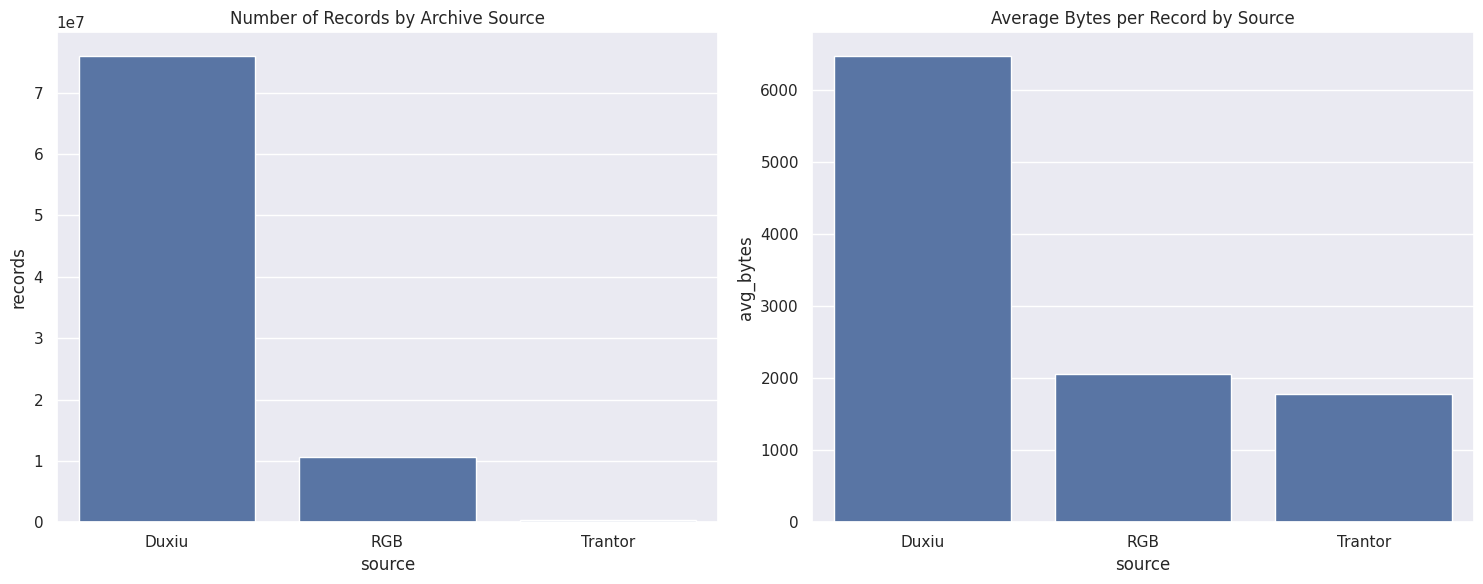

In [20]:
archive_analysis = con.execute("""
    WITH archive_stats AS (
        SELECT 'Duxiu' as source, COUNT(*) as records, AVG(CAST(byte_length AS DOUBLE)) as avg_bytes
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__duxiu_records*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'RGB' as source, COUNT(*) as records, AVG(CAST(byte_length AS DOUBLE)) as avg_bytes
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__rgb_records*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'Trantor' as source, COUNT(*) as records, AVG(CAST(byte_length AS DOUBLE)) as avg_bytes
        FROM read_parquet('/data/mariadbF/mariadb_annas_archive_meta__aacid__trantor_records*.parquet', union_by_name=True)
    )
    SELECT * FROM archive_stats
    ORDER BY records DESC;
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(data=archive_analysis, x='source', y='records', ax=ax1)
ax1.set_title('Number of Records by Archive Source')

sns.barplot(data=archive_analysis, x='source', y='avg_bytes', ax=ax2)
ax2.set_title('Average Bytes per Record by Source')

plt.tight_layout()
plt.show()

# Query 8: Series temporal analysis
## Analyzes the temporal distribution of series publications

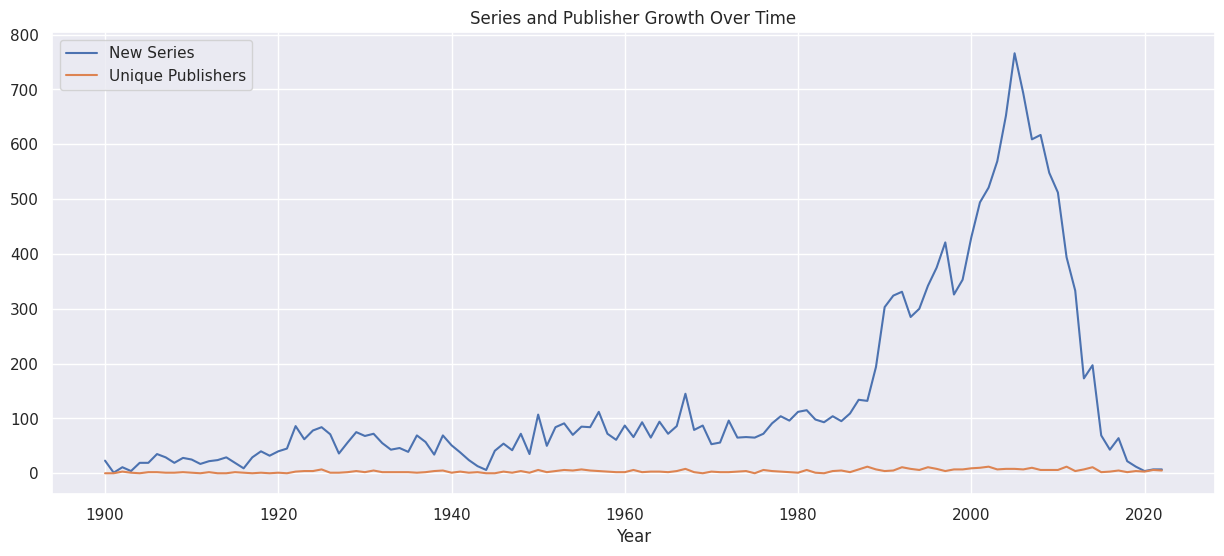

In [33]:
series_temporal = con.execute("""
    SELECT 
        EXTRACT(YEAR FROM CAST(date_start AS DATE)) as start_year,
        COUNT(*) as new_series,
        COUNT(DISTINCT publisher) as unique_publishers
    FROM read_parquet('/data/mariadbF/mariadb_libgenli_series*.parquet', union_by_name=True)
    WHERE date_start IS NOT NULL
    AND date_start != '\\N'
    AND date_start NOT LIKE '%-00-%'
    AND LENGTH(date_start) = 10
    AND SUBSTR(date_start, 6, 2) BETWEEN '01' AND '12'
    AND SUBSTR(date_start, 9, 2) BETWEEN '01' AND '31'
    AND date_start NOT LIKE '%-00'
    GROUP BY start_year
    HAVING start_year BETWEEN 1900 AND 2024
    ORDER BY start_year;
""").df()




plt.figure(figsize=(15, 6))
plt.plot(series_temporal['start_year'], series_temporal['new_series'], label='New Series')
plt.plot(series_temporal['start_year'], series_temporal['unique_publishers'], label='Unique Publishers')
plt.title('Series and Publisher Growth Over Time')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

# Query 9: File characteristics analysis
## Examines the distribution of file properties across different sources

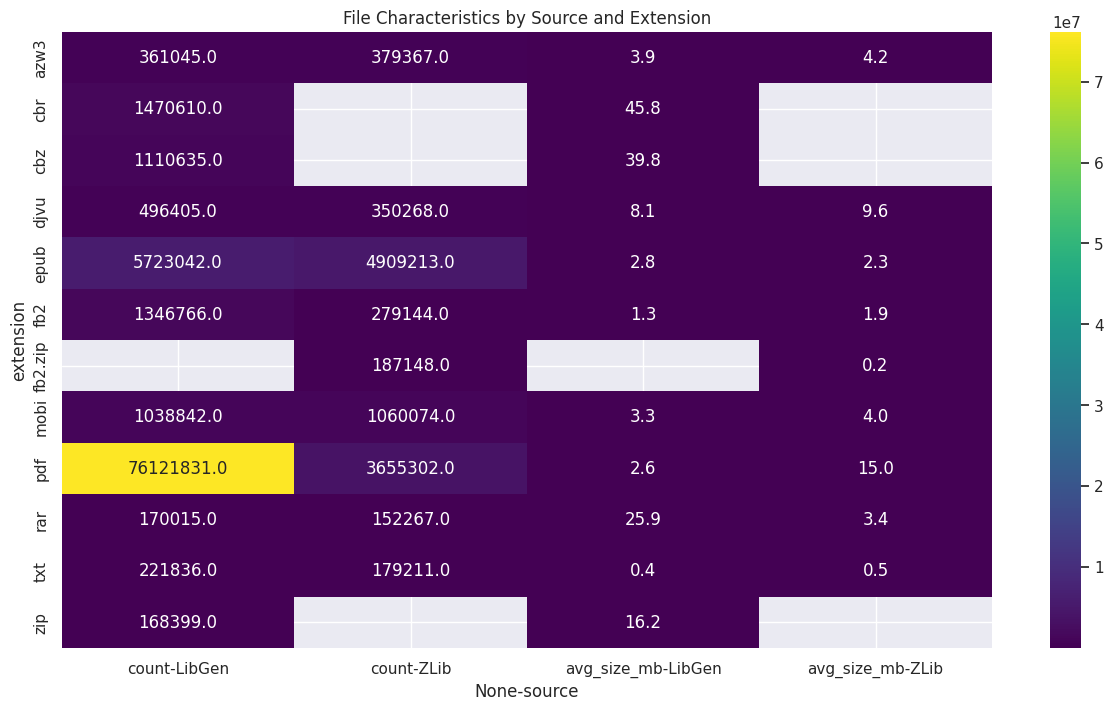

In [36]:
file_analysis = con.execute("""
    WITH file_stats AS (
        SELECT 
            'LibGen' as source,
            extension,
            COUNT(*) as count,
            AVG(CAST(NULLIF(filesize, '\\N') AS DOUBLE))/1024/1024 as avg_size_mb
        FROM read_parquet('/data/mariadbF/mariadb_libgenli_files*.parquet', union_by_name=True)
        GROUP BY extension
        UNION ALL
        SELECT 
            'ZLib' as source,
            extension,
            COUNT(*) as count,
            AVG(CAST(NULLIF(filesize, '\\N') AS DOUBLE))/1024/1024 as avg_size_mb
        FROM read_parquet('/data/mariadbF/mariadb_zlib_book*.parquet', union_by_name=True)
        GROUP BY extension
    )
    SELECT * FROM file_stats
    WHERE extension IS NOT NULL
    ORDER BY count DESC
    LIMIT 20;
""").df()


plt.figure(figsize=(15, 8))
pivot_data = file_analysis.pivot(index='extension', columns='source', values=['count', 'avg_size_mb'])
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='viridis')
plt.title('File Characteristics by Source and Extension')
plt.show()

# Query 10: ISBN analysis
## Analyzes the distribution and characteristics of ISBN records

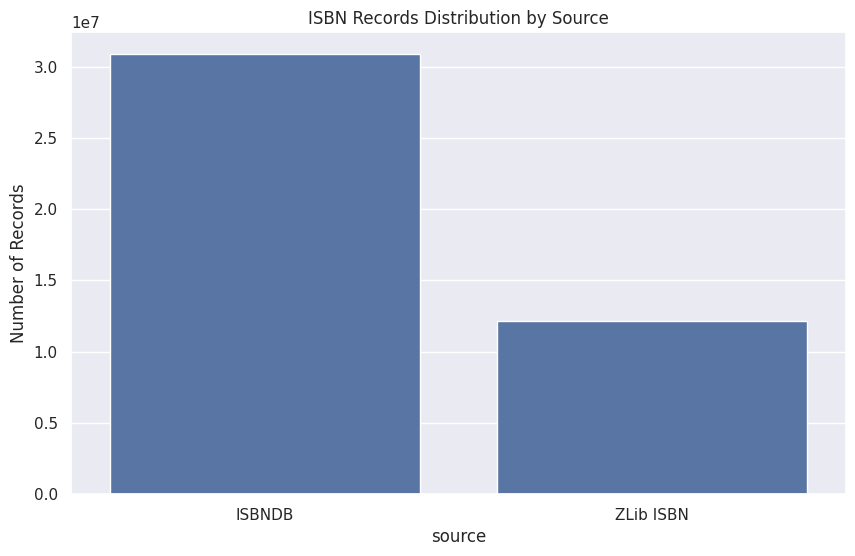

In [41]:
isbn_analysis = con.execute("""
    WITH isbn_stats AS (
        SELECT 'ISBNDB' as source, COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_isbndb_isbns*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'ZLib ISBN' as source, COUNT(*) as count
        FROM read_parquet('/data/mariadbF/mariadb_zlib_isbn*.parquet', union_by_name=True)
    )
    SELECT * FROM isbn_stats
    ORDER BY count DESC;
""").df()

plt.figure(figsize=(10, 6))
sns.barplot(data=isbn_analysis, x='source', y='count')
plt.title('ISBN Records Distribution by Source')
plt.ylabel('Number of Records')
plt.show()

# Query 11: Cross-database coverage analysis
## Analyzes overlap between different database sources

<Figure size 1000x600 with 0 Axes>

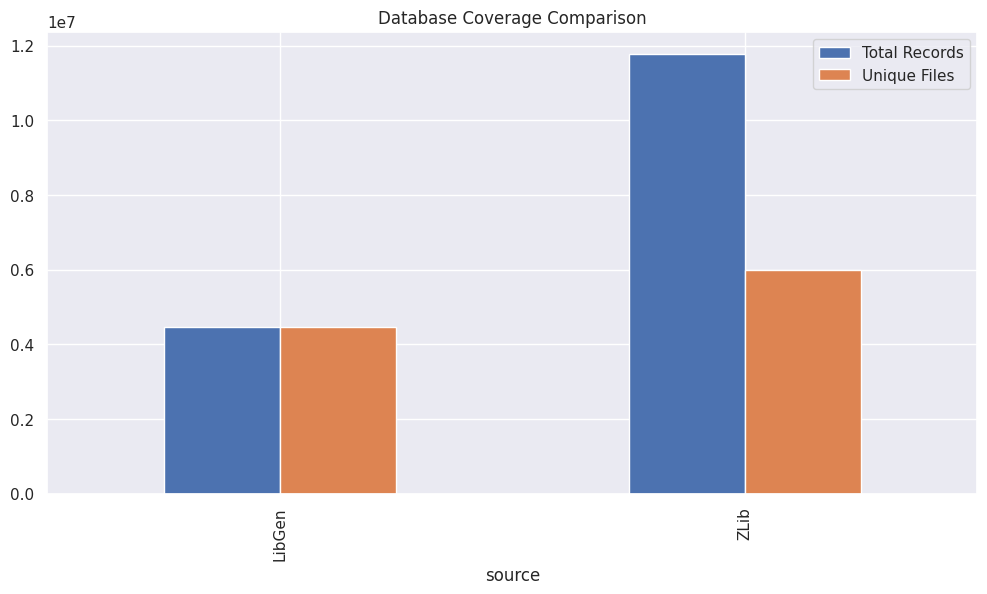

In [43]:
coverage_analysis = con.execute("""
    WITH source_md5s AS (
        SELECT 'LibGen' as source, md5
        FROM read_parquet('/data/mariadbF/mariadb_libgenrs_updated*.parquet', union_by_name=True)
        UNION ALL
        SELECT 'ZLib' as source, md5
        FROM read_parquet('/data/mariadbF/mariadb_zlib_book*.parquet', union_by_name=True)
    )
    SELECT 
        source,
        COUNT(*) as total_records,
        COUNT(DISTINCT md5) as unique_files
    FROM source_md5s
    GROUP BY source;
""").df()

plt.figure(figsize=(10, 6))
coverage_analysis.plot(x='source', y=['total_records', 'unique_files'], kind='bar')
plt.title('Database Coverage Comparison')
plt.legend(['Total Records', 'Unique Files'])
plt.show()

# Query 12: Time series analysis of uploads
## Analyzes the temporal distribution of file uploads

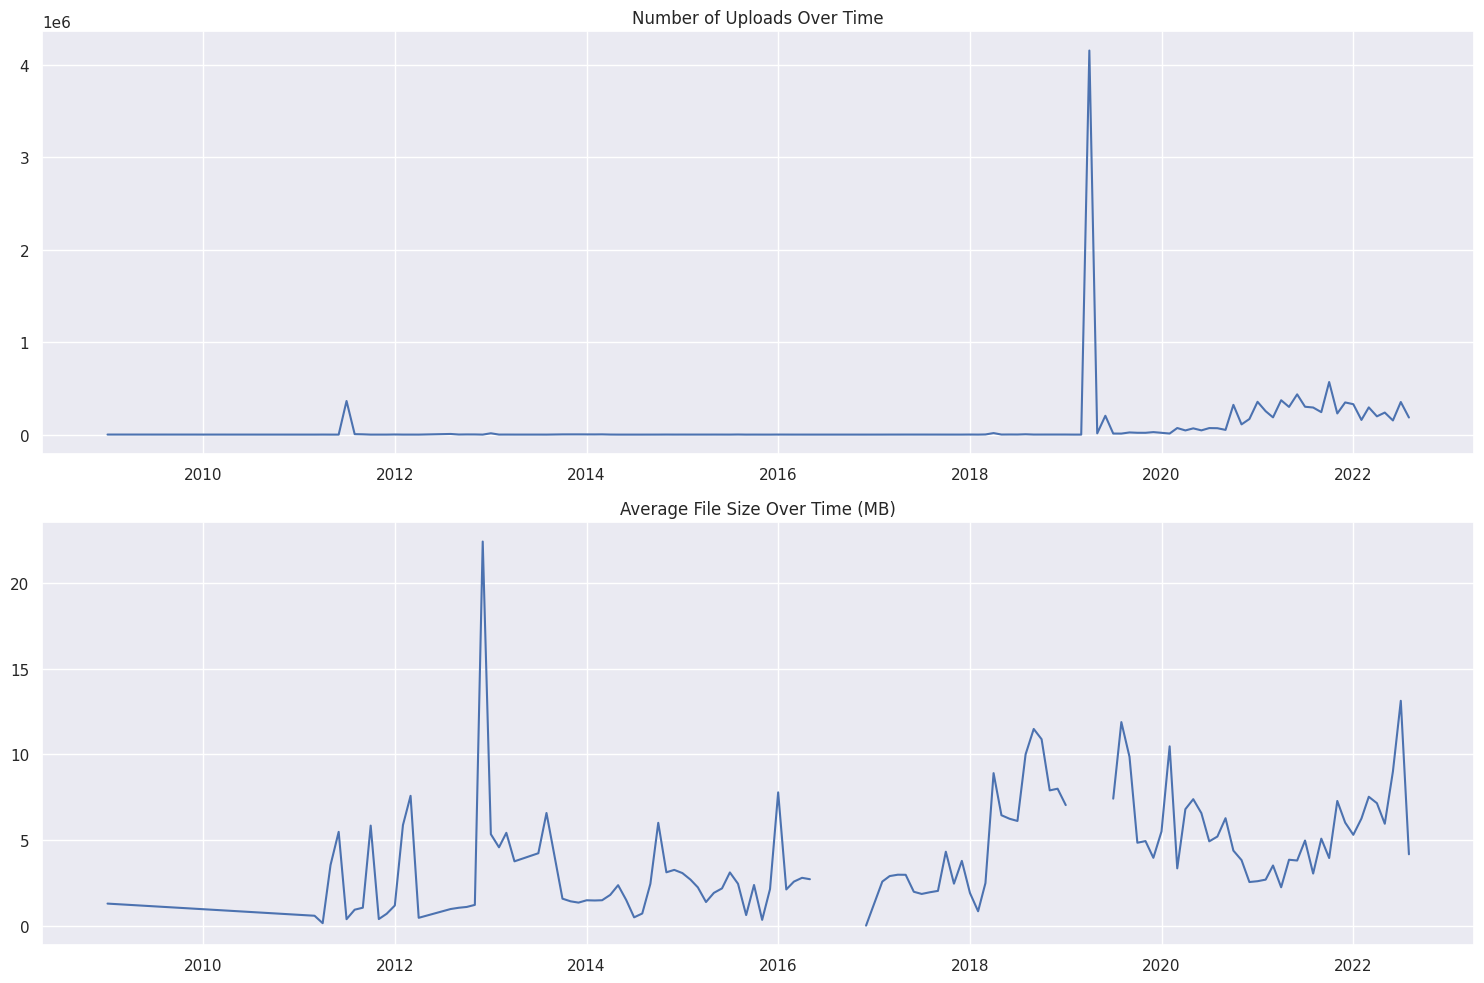

In [49]:
upload_analysis = con.execute("""
    SELECT 
        DATE_TRUNC('month', CAST(date_added AS TIMESTAMP)) as month,
        COUNT(*) as uploads,
        AVG(CASE WHEN filesize != '\\N' AND filesize IS NOT NULL THEN CAST(filesize AS DECIMAL) ELSE NULL END)/1024/1024 as avg_size_mb  -- Handling invalid filesize
    FROM read_parquet('/data/mariadbF/mariadb_zlib_book*.parquet', union_by_name=True)
    WHERE date_added IS NOT NULL
    GROUP BY month
    ORDER BY month;
""").df()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(upload_analysis['month'], upload_analysis['uploads'])
ax1.set_title('Number of Uploads Over Time')
ax1.grid(True)

ax2.plot(upload_analysis['month'], upload_analysis['avg_size_mb'])
ax2.set_title('Average File Size Over Time (MB)')
ax2.grid(True)

plt.tight_layout()
plt.show()


# Query 13: Language and translation analysis
## Analyzes language distribution and translation patterns

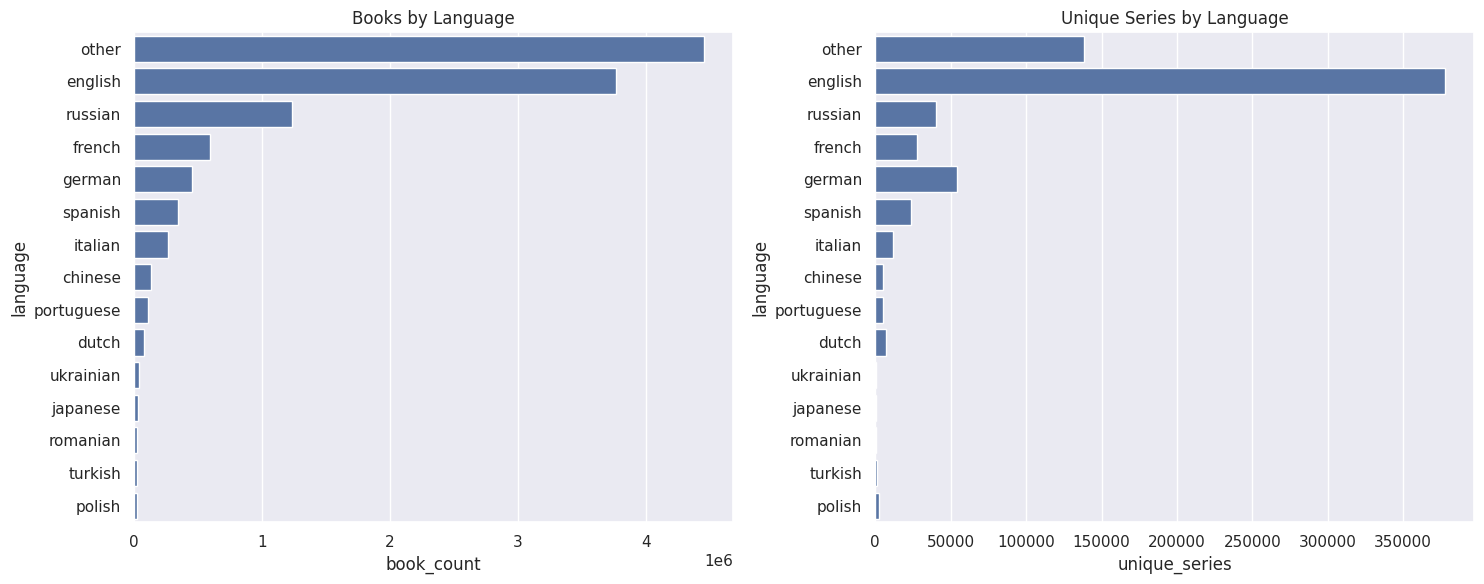

In [47]:
language_analysis = con.execute("""
    WITH lang_stats AS (
        SELECT 
            language,
            COUNT(*) as book_count,
            AVG(CASE WHEN filesize != '\\N' THEN CAST(filesize AS DECIMAL) ELSE NULL END)/1024/1024 as avg_size_mb,  -- Handling invalid filesize
            COUNT(DISTINCT series) as unique_series
        FROM read_parquet('/data/mariadbF/mariadb_zlib_book*.parquet', union_by_name=True)
        WHERE language IS NOT NULL
        GROUP BY language
    )
    SELECT * FROM lang_stats
    ORDER BY book_count DESC
    LIMIT 15;
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(data=language_analysis, x='book_count', y='language', ax=ax1)
ax1.set_title('Books by Language')

sns.barplot(data=language_analysis, x='unique_series', y='language', ax=ax2)
ax2.set_title('Unique Series by Language')

plt.tight_layout()
plt.show()